# Loading data

In [1]:
#!pip install --upgrade tensorflow
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd

In [4]:
from google.colab import drive
drive.mount('/content/drive/')
import json

Mounted at /content/drive/


In [ ]:
# Loading data
!unzip "/content/drive/MyDrive/projects/faces.zip"
!ls


In [5]:
!ls

drive  sample_data


In [7]:
keypoints_df = pd.read_csv(r'/content/Search_for_key_points_on_the_face/train.csv', index_col=0)

# Data augmentation
Initialy I'm started looking at the keras preprocessing layers. But to my disappointment i didnt understood how to use keras functionality with keypoints dataset. Initial image data is of different shapes and so keypoints. After rescaling it need to be scaled appropriately. Also if you would like to skew, rotate image or something like that - you need to change keypoints as well.

After some search i found the library called `albumentations` which can provide such kind of functionality.

In [8]:
#https://albumentations.ai/docs/examples/example_keypoints/ found this usefull library
import albumentations as A
import cv2
import random
import os

In [10]:
KEYPOINT_COLOR = (0, 255, 0) # Green

def vis_keypoints(image, keypoints, predictions=None, color=KEYPOINT_COLOR, diameter=1):
  # helper function right from albumentations documentation
  image = image.copy()
  for (x, y) in keypoints:
      cv2.circle(image, (int(x), int(y)), diameter, color, -1)
  if predictions is not None:
      cv2.putText(image, 'actl', (0,10), cv2.FONT_HERSHEY_DUPLEX, .3, (0,255,0))
      cv2.putText(image, 'pred', (0,20), cv2.FONT_HERSHEY_DUPLEX, .3, (255,0,0))

      for (x, y) in predictions:
          cv2.circle(image, (int(x), int(y)), diameter, (255, 0, 0), -1, )


  plt.figure(figsize=(6, 6))
  plt.axis('off')
  plt.imshow(image)

In [11]:
keypoints_df

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
filename,,,,,,,,,,,,,,,,,,,,,
05317.jpg,25,55,63,39,145,36,171,45,39,74,...,159,65,113,103,79,148,113,148,143,141
04767.jpg,17,32,39,27,56,22,81,16,20,39,...,86,28,56,66,45,80,59,80,74,76
05241.jpg,33,44,70,44,119,41,142,41,33,71,...,144,56,94,101,74,135,89,135,112,133
03849.jpg,96,157,222,143,389,129,517,125,153,210,...,467,188,328,339,241,451,335,453,419,441
00952.jpg,13,19,30,16,51,17,66,16,18,25,...,59,23,39,43,31,56,41,56,49,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03772.jpg,39,46,85,51,117,50,170,50,52,64,...,161,62,99,115,71,141,106,147,145,136
05191.jpg,25,19,40,17,52,17,74,18,28,30,...,77,36,50,42,30,64,53,67,62,68
05226.jpg,8,12,20,11,36,12,46,14,11,16,...,43,16,27,27,16,34,26,37,38,35


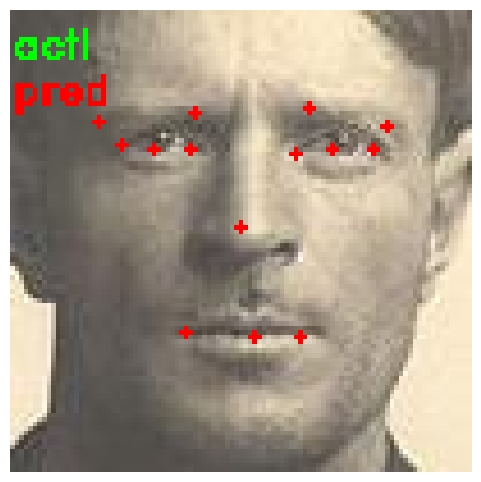

In [12]:
image = cv2.imread('/content/Search_for_key_points_on_the_face/train/00882.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
keypoints = keypoints_df.loc['00882.jpg'].values.reshape(-1,2)

vis_keypoints(image, keypoints,keypoints)

Library provides wide range of image operations to augment your data. After some research I selected folowing parameters to use in the data augmentation process. Let's define them as a pipeline.

Blame on me but i didn't check if keypoints in the dataset is setted right (for example if left eye is on the left). I didn't want to mess with it, so choosed sparing settings for rotations and perspective.


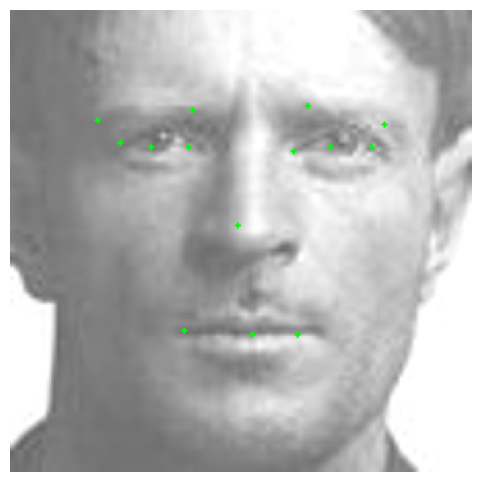

In [21]:
NUM_KEYPOINTS = 28
IMG_SIZE = 224


random.seed(69)

transform_augmentation = A.Compose([  # copy of the pipeline from the previous cell.
            A.Resize(width=IMG_SIZE, height=IMG_SIZE, always_apply=True),
            A.ToGray(always_apply=True),  # as a understood albumentations converts 3 color rgb image to 3 color gray image..
            A.RandomBrightnessContrast(p=0.8),
            A.SafeRotate((-65,65),p=0.65, border_mode=cv2.BORDER_CONSTANT),
            A.Perspective(p=0.6),
            A.Blur((3,5), p=0.2),
            A.HueSaturationValue(p=0.8),
            #A.CLAHE(p=0.3),
            ],
        keypoint_params=A.KeypointParams(format='xy',remove_invisible=False)
        )
transformed = transform_augmentation(image=image, keypoints=keypoints)
vis_keypoints(transformed['image'], transformed['keypoints'])

Next I nedd to integrate custom transformer. I will do this by writing keras data generator.

credit to [Arjun Muraleedharan](https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3) for directions. [keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)

In [33]:
from functools import lru_cache

class AugData(tf.keras.utils.Sequence):

    def __init__(self, key_df, augment, base_dir=r'/content/Search_for_key_points_on_the_face/train', batch_size=32, shuffle=True):
        self.key_df = key_df.copy()
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n = len(key_df)
        self.base_dir = base_dir
        self.augment = augment


    def __getitem__(self, index):
        batch_df = self.key_df.iloc[index*self.batch_size:(index+1)*self.batch_size]

        images = []
        keypoints = []
        for name in batch_df.index:
            r = self.augment(image=self.__load_img(name), keypoints=batch_df.loc[name].values.reshape(-1,2))
            images.append(r['image'])
            keypoints.append(np.array(r['keypoints']).flatten())

        x = np.asarray(images).astype(np.uint8)
        y = np.array(keypoints).reshape(self.batch_size,-1) / IMG_SIZE
        return x, y

    #@lru_cache(4000)
    def __load_img(self, path):
        image_path = os.path.join(self.base_dir, path)
        image = tf.keras.utils.load_img(image_path)
        #image = cv2.imread(image_path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        input_arr = tf.keras.utils.img_to_array(image)
        return input_arr


    def __len__(self):
        return self.n // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.key_df = self.key_df.sample(frac=1)  # way to shuffle dataframe by taking a sample of the whole dataframe


In [45]:

def get_model():
    # first of all lets try keras example
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    #https://keras.io/examples/vision/keypoint_detection/
    backbone = keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)  # preprocess_input normalizes image to -1 1
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
    )(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

def get_model3():
    # try a little of magling by myself
    # the idea is simple - MobileNetV2 are already trained convolutional part of the network. I just need to add dense layers to get my points position.
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    #https://keras.io/examples/vision/keypoint_detection/
    backbone = keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    #x = keras.applications.mobilenet_v2.preprocess_input(inputs)  # preprocess_input normalizes image to -1 1
    #x = backbone(x)
    #x = layers.Dropout(0.3)(x)
    x = layers.Convolution2D(32, (3,3), padding='same', use_bias=False)(inputs)
    x = layers.LeakyReLU(alpha = 0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Convolution2D(32, (3,3), padding='same', use_bias=False)(x)
    x = layers.LeakyReLU(alpha = 0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512,activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128,activation='relu')(x)
    x = layers.Dropout(0.3)(x)


    outputs = layers.Dense(
        NUM_KEYPOINTS, activation="relu"
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector2")


In [46]:
model = get_model()
model.compile(loss="mse", optimizer='Adam', metrics=['mae'])

from sklearn.model_selection import train_test_split

train, test = train_test_split(keypoints_df, train_size=0.8)
train, val = train_test_split(train, train_size=0.75)


history = model.fit(AugData(train, transform_augmentation), validation_data=AugData(test,transform_augmentation), epochs=20, use_multiprocessing=True, workers=8)

# btw I found idea that network could predict not keypoints but gaussian estimation of it. With better perfomance
model.save(r'/content/drive/MyDrive/projects/keypoint_model1_.h5')


Epoch 1/20
93/93 [==============================] - 47s 419ms/step - loss: 0.0452 - mae: 0.1508 - val_loss: 0.0123 - val_mae: 0.0839
Epoch 2/20
93/93 [==============================] - 45s 453ms/step - loss: 0.0116 - mae: 0.0823 - val_loss: 0.0119 - val_mae: 0.0829
Epoch 3/20
93/93 [==============================] - 44s 427ms/step - loss: 0.0121 - mae: 0.0840 - val_loss: 0.0119 - val_mae: 0.0837
Epoch 4/20
93/93 [==============================] - 46s 469ms/step - loss: 0.0117 - mae: 0.0826 - val_loss: 0.0114 - val_mae: 0.0817
Epoch 5/20
93/93 [==============================] - 48s 501ms/step - loss: 0.0120 - mae: 0.0834 - val_loss: 0.0117 - val_mae: 0.0819
Epoch 6/20
93/93 [==============================] - 45s 462ms/step - loss: 0.0117 - mae: 0.0827 - val_loss: 0.0113 - val_mae: 0.0802
Epoch 7/20
93/93 [==============================] - 44s 459ms/step - loss: 0.0116 - mae: 0.0824 - val_loss: 0.0111 - val_mae: 0.0815
Epoch 8/20
93/93 [==============================] - 44s 450ms/step - 

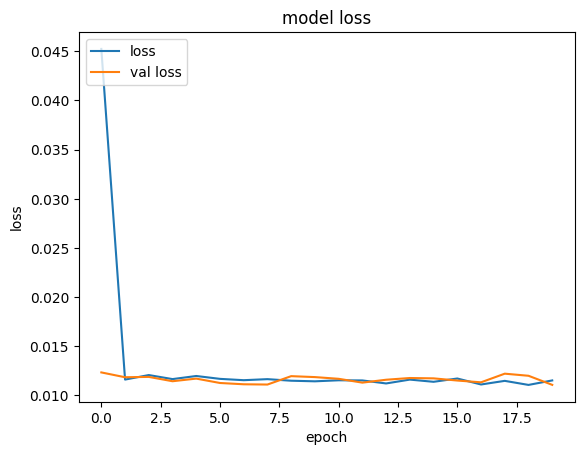

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val loss'], loc='upper left')
plt.show()

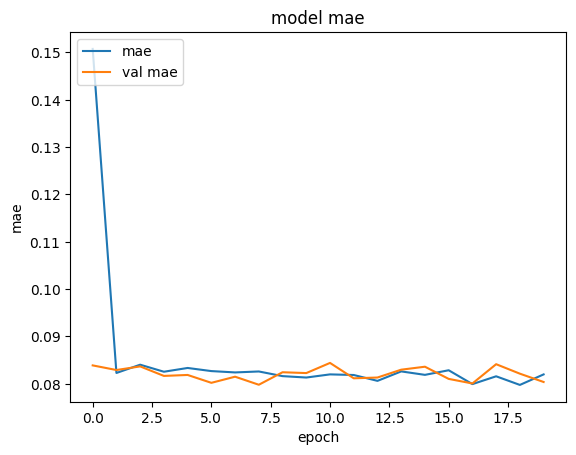

In [48]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['mae', 'val mae'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 22ms/step


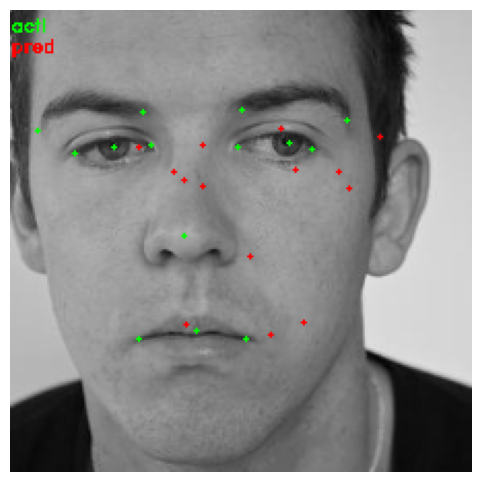

In [53]:
deploy_transform = A.Compose([  # copy of the pipeline from the previous cell.
    A.Resize(width=IMG_SIZE, height=IMG_SIZE, always_apply=True),
    A.ToGray(always_apply=True),
    ],
    keypoint_params=A.KeypointParams(format='xy',remove_invisible=False)
    )

def get_image(path, base_path=r'/content/Search_for_key_points_on_the_face/train'):
    if base_path is not None:
        image_path = os.path.join(base_path, path)
    else:
        image_path = path

    image = tf.keras.utils.load_img(image_path)
    return tf.keras.utils.img_to_array(image)


img_idx = val.index[random.randint(0,1000)]
image = get_image(img_idx)
a = deploy_transform(image=image, keypoints=keypoints_df.loc[img_idx].values.reshape(-1,2))

pred = model.predict(np.array([a['image']])) * IMG_SIZE
vis_keypoints(a['image']/255, a['keypoints'], predictions=pred[0].reshape(-1,2))

In [54]:
history_no_aug = model.fit(AugData(train, deploy_transform), validation_data=AugData(test,transform_augmentation), epochs=20, use_multiprocessing=True, workers=8)
# train same model but wo augmentation

Epoch 1/20
93/93 [==============================] - 26s 270ms/step - loss: 0.0054 - mae: 0.0547 - val_loss: 0.0158 - val_mae: 0.0941
Epoch 2/20
93/93 [==============================] - 25s 254ms/step - loss: 0.0041 - mae: 0.0466 - val_loss: 0.0156 - val_mae: 0.0942
Epoch 3/20
93/93 [==============================] - 27s 271ms/step - loss: 0.0038 - mae: 0.0445 - val_loss: 0.0155 - val_mae: 0.0943
Epoch 4/20
93/93 [==============================] - 26s 272ms/step - loss: 0.0037 - mae: 0.0436 - val_loss: 0.0149 - val_mae: 0.0909
Epoch 5/20
93/93 [==============================] - 26s 263ms/step - loss: 0.0035 - mae: 0.0423 - val_loss: 0.0156 - val_mae: 0.0931
Epoch 6/20
93/93 [==============================] - 26s 268ms/step - loss: 0.0035 - mae: 0.0418 - val_loss: 0.0142 - val_mae: 0.0874
Epoch 7/20
93/93 [==============================] - 26s 266ms/step - loss: 0.0034 - mae: 0.0410 - val_loss: 0.0143 - val_mae: 0.0874
Epoch 8/20
93/93 [==============================] - 32s 331ms/step - 

0.821 vs 0.80 result in 3% accuracy boost

As a result neural network can handle simple cases (full face pictures without rotation) but struggling with harder ones. In my opinion this could be improved by feeding algorithm with more data (increase epoches)

In [30]:
gen = AugData(val, deploy_transform)
#
res = np.zeros(32)
predictions = []
keypoints = []
for data, key in gen:
    predictions.append(model.predict(data, verbose=False))
    keypoints.append(key)

predictions = np.array(predictions).reshape(-1,28)
keypoints = np.array(keypoints).reshape(-1,28)

'mse_score',np.mean(tf.keras.metrics.mean_squared_error(predictions, keypoints))

('mse_score', 308.76530630363084)

fter learning it some time i'm found out that progress does not really changing. So I should probably try to improve model.

In [ ]:
def test_image(path):
    image = get_image(path)
    a = deploy_transform(image=image/255, keypoints=[])
    pred = model.predict(np.array([a['image']]))
    vis_keypoints((cv2.resize(image,(IMG_SIZE,IMG_SIZE)) / 255), a['keypoints'], predictions=pred[0].reshape(-1,2))

test_image(r'/content/IMG_20210509_120053.jpg')